[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum((a-b)**2)/c) with a=Var(0,2,0), b=Var(1,2,1), c=Var(2,1,2) ... OK
[pyKeOps] Compiling pykeops cpp f424240104 module ... 
[KeOps] Warning : There were warnings or errors :
ld: warning: search path '/opt/homebrew/opt/libomp/lib' not found

OK

Résultat : f.shape = torch.Size([3000, 1])
Type : torch.float32, Device : cpu


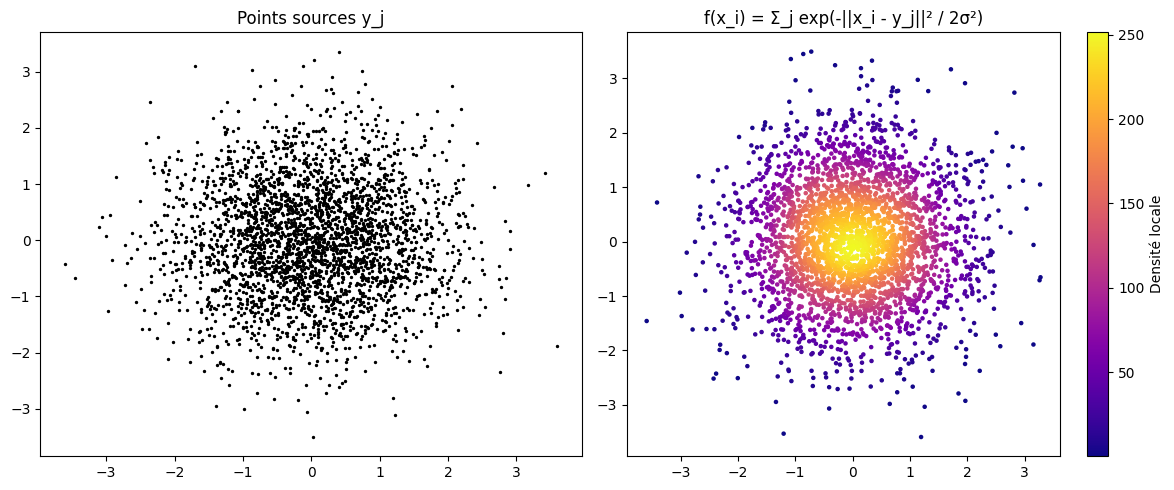

In [3]:
# ============================================================
# 🌟 Densité gaussienne avec KeOps (b_j = 1)
# ============================================================

import torch
from pykeops.torch import LazyTensor
import matplotlib.pyplot as plt

# -------------------------------
# 1. Préparation des données
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

# N points d'évaluation (x_i)
# M points "sources" (y_j)
N, M, d = 3000, 3000, 2  # augmente pour tester les perfs

# Points 2D aléatoires
x = torch.randn(N, d, device=device, dtype=dtype)
y = torch.randn(M, d, device=device, dtype=dtype)

# Largeur du noyau gaussien
sigma = 0.3

# -------------------------------
# 2. Création des LazyTensors
# -------------------------------
x_i = LazyTensor(x[:, None, :])   # (N, 1, d)
y_j = LazyTensor(y[None, :, :])   # (1, M, d)

# -------------------------------
# 3. Formule du noyau gaussien
# -------------------------------
# ||x_i - y_j||²
D_ij = ((x_i - y_j) ** 2).sum(-1)

# Noyau gaussien : exp(-||x_i - y_j||² / (2σ²))
K_ij = (- D_ij / (2 * sigma**2)).exp()

# -------------------------------
# 4. Somme sur j (densité locale)
# -------------------------------
# f_i = ∑_j K_ij  (comme si b_j = 1)
f = K_ij.sum(dim=1)

print(f"\nRésultat : f.shape = {f.shape}")
print(f"Type : {f.dtype}, Device : {f.device}")

# -------------------------------
# 5. Visualisation 2D
# -------------------------------
# On colorie chaque x_i selon la densité locale f_i
x_np = x.cpu().numpy()
y_np = y.cpu().numpy()
f_np = f.detach().cpu().numpy()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_np[:,0], y_np[:,1], color='black', s=2)
plt.title("Points sources y_j")

plt.subplot(1,2,2)
plt.scatter(x_np[:,0], x_np[:,1], c=f_np[:,0], cmap='plasma', s=5)
plt.title("f(x_i) = Σ_j exp(-||x_i - y_j||² / 2σ²)")
plt.colorbar(label="Densité locale")

plt.tight_layout()
plt.show()
